In [1]:
!pip install git+https://github.com/pesser/pytorch_diffusion.git

  Cloning https://github.com/pesser/pytorch_diffusion.git to /tmp/pip-req-build-x3331mbt
  Running command git clone --filter=blob:none --quiet https://github.com/pesser/pytorch_diffusion.git /tmp/pip-req-build-x3331mbt
  Resolved https://github.com/pesser/pytorch_diffusion.git to commit 304bdff2196db604fb66108b0bb2d4a19058b20f
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 91.2 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━

In [12]:
!rm -f /root/.cache/diffusion_models_converted/ema_diffusion_cifar10_model/model-790000.ckpt
print("Deleted potentially corrupted checkpoint file.")

Deleted potentially corrupted checkpoint file.


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 49.3 MB/s eta 0:00:00
Using device: cuda


100%|██████████| 170M/170M [00:14<00:00, 12.0MB/s] 


Training samples: 50000, Test samples: 10000
ResNet-18 model ready for CIFAR-10.
PGD attack ready.


PGD - Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Saved adversarial examples to adv_test_cifar10_pgd.npz
Instantiating


143MB [00:26, 5.41MB/s]                            


Loading checkpoint /root/.cache/diffusion_models_converted/ema_diffusion_cifar10_model/model-790000.ckpt
Moved model to cuda
Loaded pre-trained CIFAR-10 diffusion model.
Baseline adversarial accuracy: 25.90%
Purified accuracy (t=52): 86.40%
Accuracy after Ensemble Purification: 89.30%


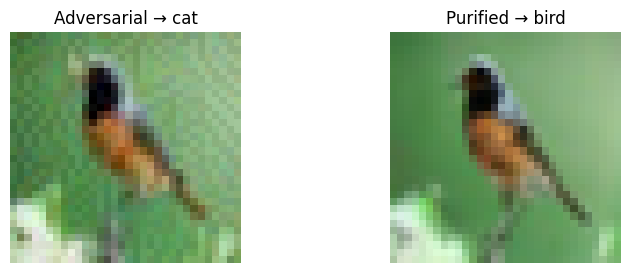

In [13]:
# %%
!pip install adversarial-robustness-toolbox git+https://github.com/pesser/pytorch_diffusion.git -q

# %%
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR

from art.attacks.evasion import ProjectedGradientDescent
from art.estimators.classification import PyTorchClassifier

import numpy as np
import matplotlib.pyplot as plt
import os
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# %%
# CIFAR-10 data setup
BATCH_SIZE = 128

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std=[0.2023, 0.1994, 0.2010])
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std=[0.2023, 0.1994, 0.2010])
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Training samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")

# %%
# Define ResNet-18 for CIFAR-10
def make_resnet18_cifar10():
    model = models.resnet18(weights=None)
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model.maxpool = nn.Identity()
    model.fc = nn.Linear(model.fc.in_features, 10)
    return model

baseline_model = make_resnet18_cifar10().to(device)
print("ResNet-18 model ready for CIFAR-10.")

# %%
# Training function
def train_model(model, loader, optimizer, criterion, epochs, scheduler=None):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * data.size(0)
            correct += (outputs.argmax(1) == target).sum().item()

        acc = 100 * correct / len(loader.dataset)
        print(f"Epoch {epoch+1}/{epochs}: Loss={running_loss/len(loader.dataset):.4f}, Acc={acc:.2f}%")
        if scheduler:
            scheduler.step()

# %%
LEARNING_RATE = 0.001
EPOCHS_BASELINE = 25
optimizer = optim.Adam(baseline_model.parameters(), lr=LEARNING_RATE)
scheduler = StepLR(optimizer, step_size=20, gamma=0.1)
criterion = nn.CrossEntropyLoss()

# Uncomment to train baseline (skip if pretrained)
# train_model(baseline_model, train_loader, optimizer, criterion, EPOCHS_BASELINE, scheduler)
# torch.save(baseline_model.state_dict(), "resnet18_cifar10_baseline.pth")

# %%
# Load baseline model (for attack + purification)
model_path = "/kaggle/input/baseline-model/pytorch/default/1/temp_baseline_resnet_cifar.pth"
baseline_model.load_state_dict(torch.load(model_path, map_location=device))
baseline_model.eval()

# %%
# Adversarial Attack (PGD)
art_classifier = PyTorchClassifier(
    model=baseline_model,
    loss=criterion,
    optimizer=None,
    input_shape=(3, 32, 32),
    nb_classes=10,
    device_type=device.type
)

pgd_attack = ProjectedGradientDescent(
    art_classifier,
    eps=8/255,
    eps_step=2/255,
    max_iter=10,
    batch_size=BATCH_SIZE
)

print("PGD attack ready.")

# %%
# Generate adversarial samples
test_images_np = test_dataset.data.transpose(0, 3, 1, 2).astype(np.float32) / 255.0
test_labels_np = np.array(test_dataset.targets)
adversarial_images_np = pgd_attack.generate(x=test_images_np[:1000])
np.savez("adv_test_cifar10_pgd.npz", images=adversarial_images_np, labels=test_labels_np[:1000])
print("Saved adversarial examples to adv_test_cifar10_pgd.npz")

# %%
# Diffusion Purifier
from pytorch_diffusion import Diffusion

diffusion_wrapper = Diffusion.from_pretrained("ema_cifar10")
diffusion_wrapper.model.eval()
print("Loaded pre-trained CIFAR-10 diffusion model.")

# %%
# Normalization
CIFAR_MEAN = torch.tensor([0.4914, 0.4822, 0.4465]).view(1, 3, 1, 1).to(device)
CIFAR_STD = torch.tensor([0.2023, 0.1994, 0.2010]).view(1, 3, 1, 1).to(device)

def normalize_cifar10(x): return (x - CIFAR_MEAN) / CIFAR_STD

# %%
@torch.no_grad()
def purify_image(x_adv, diffusion_wrapper, timestep):
    """DiffPure purification process."""
    x_adv_scaled = (x_adv * 2) - 1
    x_t = diffusion_wrapper.diffuse(x_adv_scaled.shape[0], timestep - 1, x_adv_scaled)
    x_pur = x_t
    for i in reversed(range(1, timestep)):
        x_pur = diffusion_wrapper.denoise(n=x_adv.shape[0], n_steps=1, x=x_pur, curr_step=i)
    x_pur = torch.clamp((x_pur + 1) / 2, 0, 1)
    return x_pur

# %%
def purify_ensemble(x_adv, diffusion_wrapper, classifier, timesteps, batch_size=64):
    preds_all = []
    classifier.eval()
    for start in range(0, len(x_adv), batch_size):
        batch = x_adv[start:start+batch_size]
        logits_all = []
        for t in timesteps:
            purified = purify_image(batch, diffusion_wrapper, t)
            normed = normalize_cifar10(purified)
            logits = classifier(normed)
            logits_all.append(logits)
        avg_logits = torch.mean(torch.stack(logits_all), dim=0)
        preds_all.append(avg_logits.argmax(1).cpu())
    return torch.cat(preds_all)

# %%
# Load adversarial test set
adv_data = np.load("adv_test_cifar10_pgd.npz")
adv_images = torch.tensor(adv_data['images']).to(device)
adv_labels = torch.tensor(adv_data['labels']).long().to(device)

# Evaluate before and after purification
with torch.no_grad():
    outputs_adv = baseline_model(normalize_cifar10(adv_images[:1000]))
    acc_adv = (outputs_adv.argmax(1) == adv_labels[:1000]).float().mean().item() * 100

print(f"Baseline adversarial accuracy: {acc_adv:.2f}%")

timestep = 52
purified_imgs = purify_image(adv_images[:1000], diffusion_wrapper, timestep)
with torch.no_grad():
    outputs_pur = baseline_model(normalize_cifar10(purified_imgs))
    acc_pur = (outputs_pur.argmax(1) == adv_labels[:1000]).float().mean().item() * 100

print(f"Purified accuracy (t={timestep}): {acc_pur:.2f}%")

# %%
# Ensemble purification
timesteps = [40, 52, 60, 70]
ensemble_preds = purify_ensemble(adv_images[:1000], diffusion_wrapper, baseline_model, timesteps)
ensemble_acc = (ensemble_preds == adv_labels[:1000].cpu()).float().mean().item() * 100
print(f"Accuracy after Ensemble Purification: {ensemble_acc:.2f}%")

# %%
# Visualization
idx = random.randint(0, 1000-1)
classes = ('plane','car','bird','cat','deer','dog','frog','horse','ship','truck')

clean = adv_images[idx:idx+1]
purified = purify_image(clean, diffusion_wrapper, timestep)

with torch.no_grad():
    pred_adv = baseline_model(normalize_cifar10(clean)).argmax(1).item()
    pred_pur = baseline_model(normalize_cifar10(purified)).argmax(1).item()

plt.figure(figsize=(9,3))
plt.subplot(1,2,1)
plt.imshow(clean.squeeze().permute(1,2,0).cpu())
plt.title(f"Adversarial → {classes[pred_adv]}")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(purified.squeeze().permute(1,2,0).cpu())
plt.title(f"Purified → {classes[pred_pur]}")
plt.axis('off')
plt.show()